# Preprocessing Module with Features FFT Data
This module adds the target column of tremor to features data according to
MDS-UPDRS patients test.

## Required Imports

In [51]:
import re
import pickle


import pandas as pd
import numpy as np
import seaborn as sns

from src.settings import ROOT_DIR
from src.preprocessing.get_anon_id import get_anon_id
from src.utils.data_split import save_and_split

## Load Data
Loads Features and MDS-UPDRS

In [52]:
#Load Features
data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_fft_features.pkl')

#Load MDS-UPDRS
patients_mds:pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'patients_mdsupdrs_results.xlsx')
patients_mds_used_columns = ['Cédula','Temblor postural – Mano derecha','Temblor postural – Mano izquierda','Temblor de acción – Mano derecha','Temblor de acción – Mano izquierda']
patients_mds = patients_mds[patients_mds_used_columns]

In [53]:
patients_mds['Cédula'] = patients_mds['Cédula'].astype('string')

## MDS-UPDRS Target extraction

Is necessary to split patients and controls to cross ids with MDS-UPDRS test:

In [54]:
patients_mds['anon_id'] = patients_mds['Cédula'].apply(get_anon_id)
patients_mds_used_columns.pop(0)

'Cédula'

In [55]:
tremor_list = []
for i in range(len(patients_mds)):
    tremor_list.append(1 if patients_mds.loc[i, patients_mds_used_columns].sum() > 0 else 0)

In [56]:
patients_mds['tremor'] = tremor_list
patients_mds = patients_mds[['anon_id', 'tremor']]

In [57]:
patients_mds['tremor'].value_counts()

tremor
0    51
1    39
Name: count, dtype: int64

In [58]:
patients_mds = patients_mds[patients_mds['anon_id'].ne('')]

In [59]:
patients = data[data['PD'] == 1].copy()
controls = data[data['PD'] == 0].copy()

In [60]:
len(patients)

10284

In [61]:
mds_id_list = set(patients_mds['anon_id'].tolist())
df_id_list = set(patients['anon_id'].tolist())
intersection_ids = df_id_list.intersection(mds_id_list)
print(len(intersection_ids))

61


In [62]:
patients_mds = patients_mds[patients_mds['anon_id'].isin(intersection_ids)]

In [63]:
print('Patients registers before merge:',len(patients))
patients = pd.merge(patients, patients_mds, how='inner')
patients.dropna(inplace=True)
print('Patients registers after merge:',len(patients))

Patients registers before merge: 10284
Patients registers after merge: 7081


In [64]:
controls['tremor'] = [0 for i in range(len(controls))]

In [65]:
tremor_data = pd.concat([patients, controls])

In [66]:
len(tremor_data)

16547

## Removal of not necessary columns: Spine columns

In [67]:
pattern = re.compile(".*.spine")
dropable_columns = list(filter(pattern.match, tremor_data.columns.tolist()))
dropable_columns

['fft_imu_gyroX_spine_mean',
 'fft_imu_gyroX_spine_std',
 'fft_imu_gyroX_spine_mean_abs_dev',
 'fft_imu_gyroX_spine_min',
 'fft_imu_gyroX_spine_max',
 'fft_imu_gyroX_spine_range',
 'fft_imu_gyroX_spine_median',
 'fft_imu_gyroX_spine_median_abs_dev',
 'fft_imu_gyroX_spine_interquartile_range',
 'fft_imu_gyroX_spine_negative_count',
 'fft_imu_gyroX_spine_positive_count',
 'fft_imu_gyroX_spine_above_mean_count',
 'fft_imu_gyroX_spine_local_maxima_count',
 'fft_imu_gyroX_spine_skewness',
 'fft_imu_gyroX_spine_kurtosis',
 'fft_imu_gyroY_spine_mean',
 'fft_imu_gyroY_spine_std',
 'fft_imu_gyroY_spine_mean_abs_dev',
 'fft_imu_gyroY_spine_min',
 'fft_imu_gyroY_spine_max',
 'fft_imu_gyroY_spine_range',
 'fft_imu_gyroY_spine_median',
 'fft_imu_gyroY_spine_median_abs_dev',
 'fft_imu_gyroY_spine_interquartile_range',
 'fft_imu_gyroY_spine_negative_count',
 'fft_imu_gyroY_spine_positive_count',
 'fft_imu_gyroY_spine_above_mean_count',
 'fft_imu_gyroY_spine_local_maxima_count',
 'fft_imu_gyroY_spine_

In [68]:
tremor_data.drop(columns=dropable_columns)

,anon_id,date_measure,window_number,first_timestamp,fft_imu_gyroX_right_mean,fft_imu_gyroX_right_std,fft_imu_gyroX_right_mean_abs_dev,fft_imu_gyroX_right_min,fft_imu_gyroX_right_max,fft_imu_gyroX_right_range,...,fft_imu_angularZ_right_median_abs_dev,fft_imu_angularZ_right_interquartile_range,fft_imu_angularZ_right_negative_count,fft_imu_angularZ_right_positive_count,fft_imu_angularZ_right_above_mean_count,fft_imu_angularZ_right_local_maxima_count,fft_imu_angularZ_right_skewness,fft_imu_angularZ_right_kurtosis,PD,tremor
0,9,2023-9-29-11-53-21,1,0.0,4492.082286,2398.058032,1853.206304,351.967162,10818.766878,10466.799716,...,1822.900955,3473.157916,0,50,23,44,0.891896,0.425542,1,0
1,9,2023-9-29-11-53-21,2,532.0,4264.240537,2839.961398,2047.382986,16.400323,12519.401740,12503.001417,...,1587.989902,3748.942714,0,50,20,45,0.697991,-0.387869,1,0
2,9,2023-9-29-11-53-21,3,1029.0,4044.778170,3058.455093,2368.328112,16.400323,12519.401740,12503.001417,...,1741.632405,3483.276467,0,50,23,43,0.806199,1.182202,1,0
3,9,2023-9-29-11-53-21,4,1587.0,3271.885272,2020.474359,1698.804177,115.992487,8035.638789,7919.646301,...,2066.071841,6365.668398,0,50,15,42,1.069827,0.077747,1,0
4,9,2023-9-29-11-53-21,5,2121.0,4497.486671,3248.411077,2613.529048,115.992487,13768.103200,13652.110712,...,3076.880150,6029.997347,0,50,19,41,0.504728,-0.474809,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,179,2023-6-17-10-39-17,19746,38028.0,8970.762648,6562.960152,5687.150631,220.089905,22650.245743,22430.155838,...,7547.660381,15058.346713,0,50,22,39,0.262316,-0.762577,0,0
19746,179,2023-6-17-10-39-17,19747,39053.0,8237.769279,6322.666756,5462.910166,220.089905,21838.377130,21618.287225,...,7206.614410,14317.339562,0,50,21,40,0.028537,-1.077674,0,0
19747,179,2023-6-17-10-39-17,19748,40080.0,8964.414573,6346.216096,5533.135825,324.519139,21838.377130,21513.857991,...,7169.289691,13825.596914,0,50,23,42,-0.065816,-1.170728,0,0
19748,179,2023-6-17-10-39-17,19749,41105.0,10376.550930,6919.783178,5824.883175,617.791034,28002.682260,27384.891226,...,6521.136522,13467.595976,0,50,27,43,-0.257296,-0.991950,0,0


## Feature Selection

In [69]:
correlation = tremor_data[tremor_data.columns.tolist()[4:]].corr().abs()['tremor']

In [70]:
sorted(correlation.tolist())

[0.00020844821249725828,
 0.01059072700510842,
 0.01059072700510842,
 0.01608568393873651,
 0.023277415622920017,
 0.02853425332295113,
 0.030929596895278025,
 0.052445142413611964,
 0.05469738538235348,
 0.05524962207648962,
 0.057369794494938356,
 0.07471795381490369,
 0.07494998243281316,
 0.07775979225612946,
 0.08089291920332324,
 0.08386413871432002,
 0.08744033410269031,
 0.08807953547609837,
 0.09266781167615153,
 0.09331851711027872,
 0.10120695551720389,
 0.1891228573123642,
 0.1906451770941583,
 0.19571116856145848,
 0.20119171168846894,
 0.20782010278375246,
 0.2115795930015944,
 0.2210697466083073,
 0.22673352728612278,
 0.22675808412039986,
 0.2460527901682587,
 0.26587400355727325,
 nan,
 nan,
 0.005930540802842902,
 0.01059072700510842,
 0.01059072700510842,
 0.015960919433734226,
 0.017538719810670483,
 0.020594055949266356,
 0.02575923937746348,
 0.029591125124137103,
 0.03193808955658481,
 0.03884576288480581,
 0.03989200264007158,
 0.04385401093994303,
 0.0446026858

In [71]:
best_correlations_columns = []
for index, value in correlation.items():
    if value > 0.3:
        best_correlations_columns.append(index)

best_correlations_columns

['PD', 'tremor']

In [72]:
len(best_correlations_columns)

2

<Axes: >

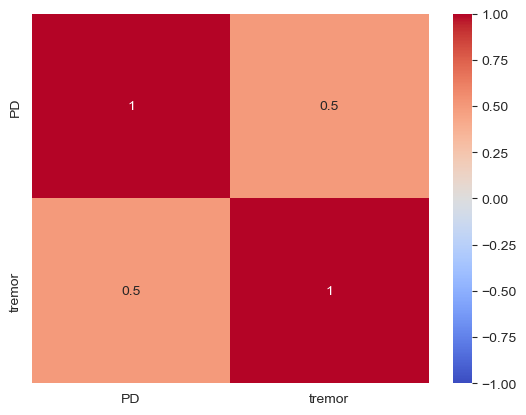

In [73]:
tremor_data = tremor_data[best_correlations_columns]
sns.heatmap(tremor_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

### Drop of highly correlated columns

In [74]:
correlation = tremor_data.corr().abs()
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

[]

In [75]:
len(to_drop)

0

In [76]:
tremor_data.drop(to_drop, axis=1, inplace=True)

In [77]:
#PD is not the target of this module so it will be deleted
tremor_data.drop(columns=['PD'], inplace=True)

<Axes: >

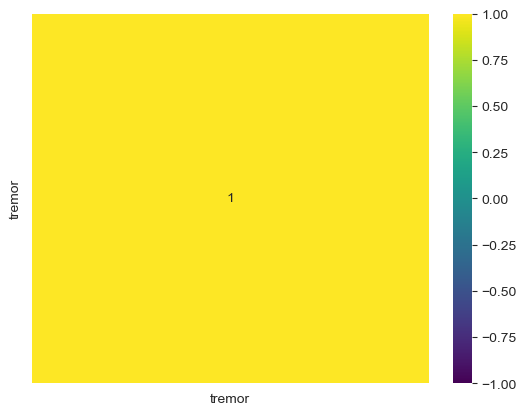

In [78]:
sns.heatmap(tremor_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'viridis')

## Save data

Due to any characteristic is correlated in more than 0.3 to the target value, this features dataset will not be stored.

In [57]:
#save_and_split(tremor_data, 'tremor-fft-features')